## As our data depends on time, we are going to analyze it as a Time Series.

### In this analysis we use all observations of our dataset.

### Import libraries

In [39]:
import pandas as pd
import itertools
import statsmodels.api as sm
from pylab import rcParams
import math

#To plot
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
cf.go_offline()
#matplotlib.rcParams.update({'font.size': 15}) #Change the axis size of all plots


### Import and check the data

In [2]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


In [5]:
data.isnull().sum()

obs              0
year             0
month            0
day              0
date             0
latitude         0
longitude        0
zon.winds    25163
mer.winds    25162
humidity     65761
air temp.    18237
s.s.temp.    17007
dtype: int64

### Plot the data to see a first glimpse

In [6]:
g = data.groupby(by='date').mean()

In [7]:
g.shape

(6371, 11)

In [8]:
g.isnull().sum()

obs             0
year            0
month           0
day             0
latitude        0
longitude       0
zon.winds       0
mer.winds       0
humidity     3248
air temp.       0
s.s.temp.     105
dtype: int64

In [9]:
g['s.s.temp.'].rolling(window= 30).mean().iplot(kind='line', xTitle='Date',
           yTitle='Sea Surface Temperature (ºC))', title='Sea Surface Temperature between 1984 and  1998')

### Clean and take the data for the analysis

#### We group our data by months and check nan values.

In [17]:
y = data.groupby(by='date').mean()['s.s.temp.'].resample('MS').mean()
y.isnull().sum()

12

#### If, we then only take values from October 1983, can avoid some nan values that are present in the data set. 

In [18]:
y_rev = y[y.index > '1983-10-01']

In [21]:
y_rev.isnull().sum()

0

#### Finally, we plot the cleaned and ready-to-analyze data

In [23]:
y_rev.iplot(kind='line', xTitle='Time',
           yTitle='Sea Temperature (ºC)', title='Sea surface temperature between 1984 and  1998')

## Decomposition Analysis

#### Descompose the time-series into three distinct components: trend, seasonality and noise

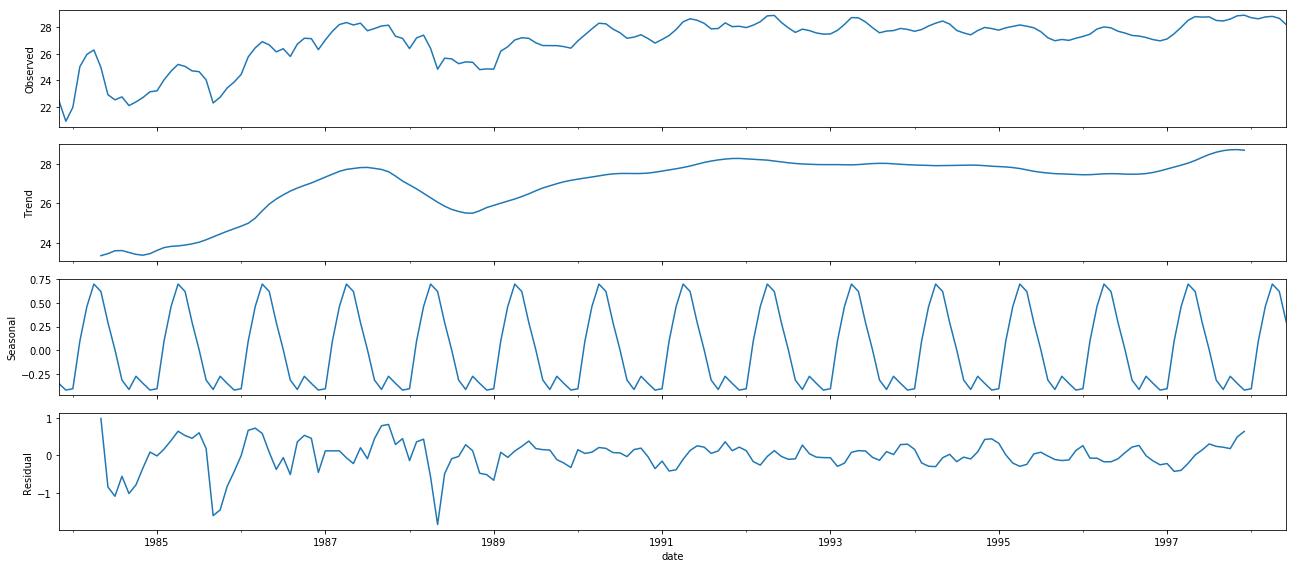

In [22]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='additive')
fig = decomposition.plot()
plt.show()

## SARIMAX method

#### In order to apply this method, I follow the following SARIMAX guide: "https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3"

Autoregressive Integrated Moving Average, or ARIMA is a well established method for Time Series Analysis. However, it does not support seasonal data. As our data has seasonal components, we will use seasonal ARIMA or SARIMA instead. 

Moreover, ARIMA and SARIMA are only valid to stationary data. As the meteorological data we have tends to repeat over years (we will discard any climate change effect), we can considered it stationary. 

 Therefore, in order to analyze and forecast the meridional winds vs Time, we use the SARIMAX method.
The additional X means that the method is able to manage exogenous variables (variables that are not affected by others variables in the method). However, in this analysis we are not going to use them.

First, we need to find the most optimal SARIMAX parameters that fits with our data. To do so, we generate a combination of parameters that will be evaluated with our data. 

In [24]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [25]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [27]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_rev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1652.2946509706464
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1362.1962082013556
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:543.8390562277264
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:504.7485867138647
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:535.8968074011491


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:528.5197513889882
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:507.7387171075796
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:468.35270595232817
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1411.054924808875
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1137.7586914423355
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:395.9806468544839
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:366.3572721848164
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:398.4501883292087
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:379.20292051606214
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.93215708762403
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:339.4129996428734
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:269.96117057814865
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:169.58292476638
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:259.15830525680536
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:162.18526972351214
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:162.7697298570484
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:154.1606199484603
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:181.2632134245692
ARIMA

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Thus, the parameters that are related to our most optimal fit are:

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:154.23745891138705

#### Fitting the SARIMAX model with the previously found values. 

In [28]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_rev,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarimax_model.fit()

# We plot the result summary
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1821      0.050      3.664      0.000       0.085       0.280
ar.S.L12       0.2840      0.043      6.556      0.000       0.199       0.369
sigma2         0.1462      0.010     14.414      0.000       0.126       0.166


#### In order to visualize check the fitness of our model, we plot the diagnostics graphs.

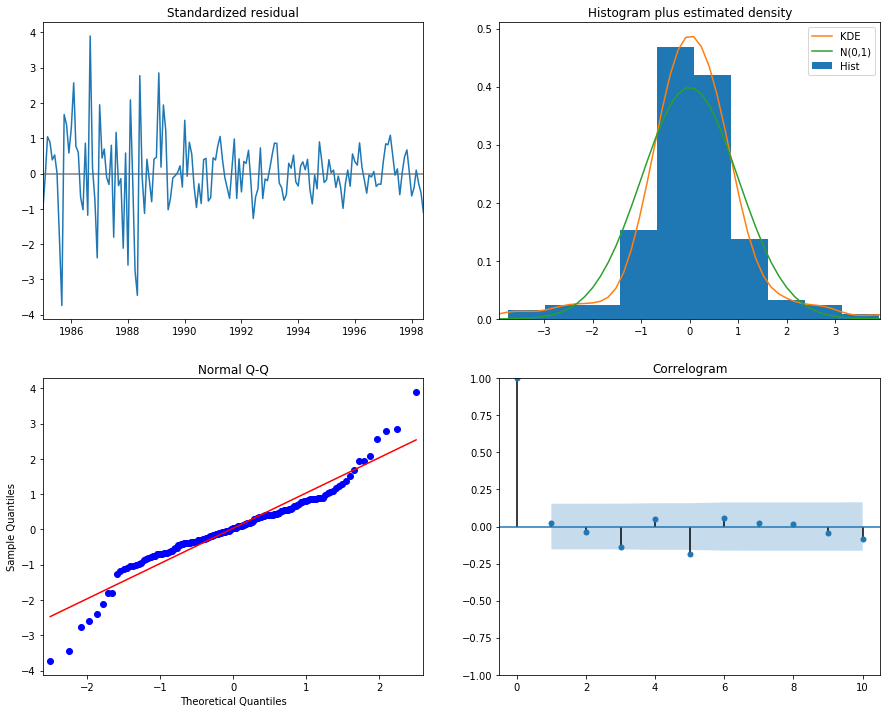

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), except for the first and last section of the regression. This is an indication that the residuals are not very well normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Model prediction. 
#### We predict the meridional winds of the last years of data. 

In [34]:
pred = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

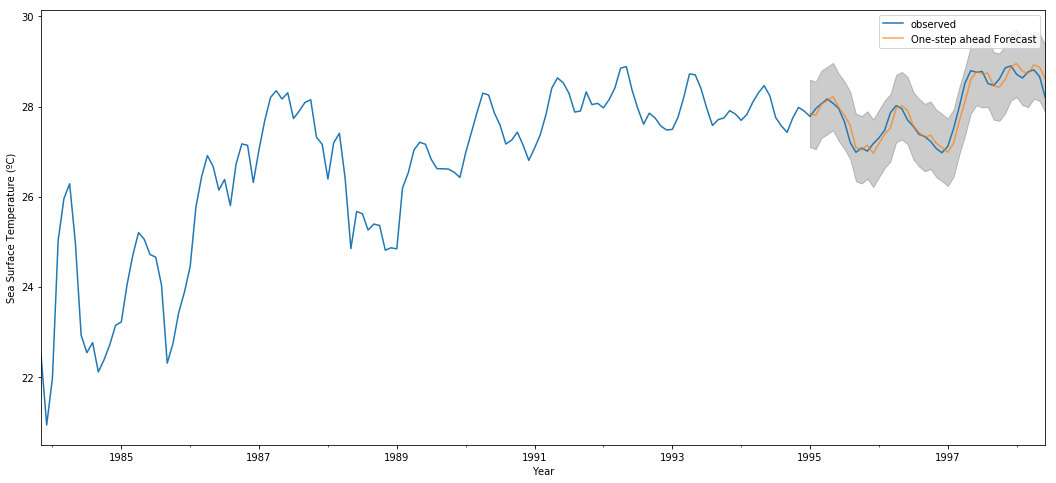

In [35]:

ax = y_rev['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Sea Surface Temperature (ºC)')
plt.legend()

#plt.savefig('../Images_&_graphs/SST_ONI_pred_dyn_false.png') - to save an image of the plot
plt.show()

#### Model accuracy. 
We will use the MSE (Mean Squared Error) which summarize the average error of our forecasts. 

In [36]:
y_forecasted = pred.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.03


However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

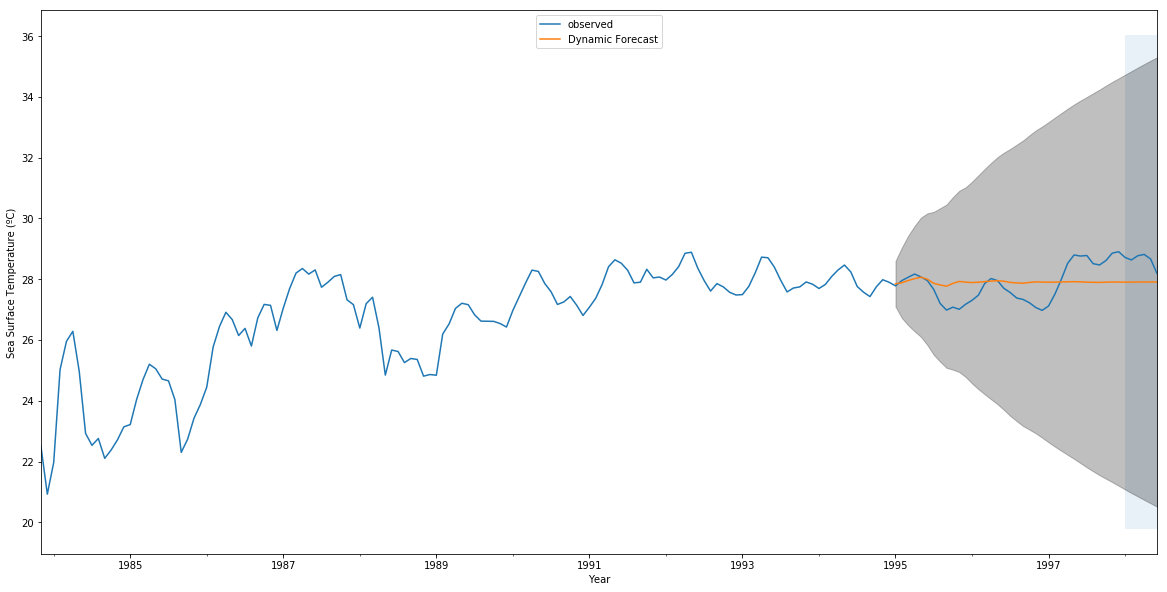

In [37]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y_rev.plot(label='observed', figsize=(20, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1998-01-01'),
                 y_rev.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Year')
ax.set_ylabel('Sea Surface Temperature (ºC)')
ax.legend(loc=9)

# plt.savefig('../Images_&_graphs/SST_ONI_pred_dyn_true.png') - to save an image of the plot

plt.show()

In [40]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = math.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 0.39
The Root Mean Squared Error of our forecasts is 0.62


The MSE is higher than before. This is expected as we are dynamic forecast relies less on historical data. 

### Forecasting the model

#### Finally, we forecast our model predicting 100 months ahead. 

In [41]:
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



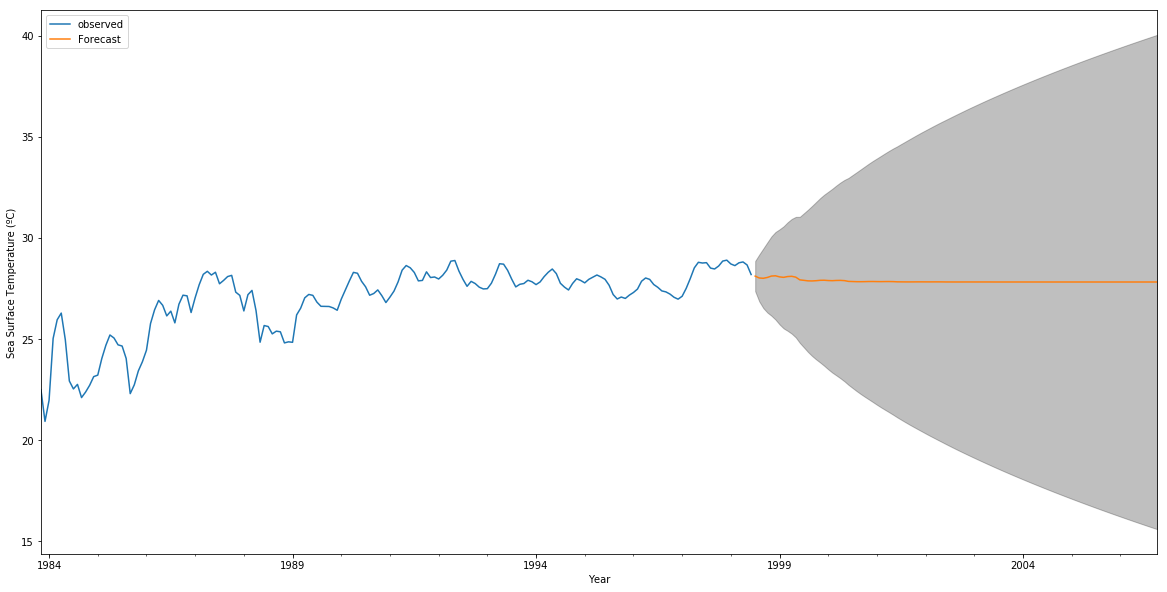

In [42]:
ax = y_rev.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sea Surface Temperature (ºC)')

ax.legend(loc=2)

#plt.savefig('../Images_&_graphs/SST_ONI_forecast.png') - to save an image of the plot


plt.show()
